This notebook illustrates how time series data can be embedded into images using two different methods : (a) Recurrence Plots (RP) and (b) Gramian Angular Field (GAF). 

The images thus formed are classified using a CNN based classifier. 

In [158]:
#importing libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys,os
from mpl_toolkits.axes_grid1 import make_axes_locatable

Defining functions

In [159]:
#piecewise aggregate approximation
def paa(data,ds_factor=2):
    #input datatype data : ndarray, dxn, d-number of series, n-number of samples in each series
    #input datatype ds_factor : int, downsampling factor, default is 2
    #output datatype ds_series : ndarray, downsampled time series
    
    d,ds_b = data.shape
    ds_length = int(ds_b/ds_factor)
    ds_series = np.empty(shape = (d,ds_length))
    for i in range (ds_length):
        ds_series[:,i] = np.mean(data[:,i*ds_factor:(i+1)*ds_factor],axis=1)
    return ds_series

#imaging time series as unthresholded recurrence plot
def r_plot(data,delay=0):
    #input datatype data : ndarray, 1xn, n-number of samples in each series
    #input datatype delay : int, delay embedding for RP formation, default value is 1
    #output datatype rp : ndarray, nxn, unthresholded recurrence plot for series
    
    transformed = np.zeros([2,len(data)-delay])
    transformed[0,:] = data[0:len(data)-delay]
    transformed[1,:] = data[delay:len(data)]
    rp = np.zeros([len(data)-delay,len(data)-delay])
    for i in range(len(rp)):
        temp = np.tile(transformed[:,i],(len(rp),1)).T-transformed
        temp2 = np.square(temp)
        rp[i,:] = np.sum(temp2,axis=0)
    return np.array(rp)

#rescaling series into range [0,1]
def rescale(data):
    #input datatype data: ndarray , dxn, d-number of series, n-number of samples in each series
    #output datatype rescaled: ndarray, dxn
    
    num=data-np.tile(np.mat(data.min(axis=1)).T,(1,np.shape(data)[1]))
    denom=np.tile(np.mat(data.max(axis=1)).T,(1,np.shape(data)[1]))-np.tile(np.mat(data.min(axis=1)).T,(1,np.shape(data)[1]))
    rescaled=np.multiply(num,1/denom)
    return rescaled

#imaging time series as Gramian Angular Difference Field (GADF)
def polar_rep (data):
    #input datatype data : ndarray, 1xn, n-number of samples in each series
    #output datatype phi : ndarray, 1xn 
    #output datatype r : ndarray, 1xn
    
    phi=np.arccos(data)
    r=(np.arange(0,np.shape(data)[1])/np.shape(data)[1])+0.1
    return phi,r
    
def GADF(data):
    #input datatype data : ndarray, 1xn, n-number of samples in each series
    #output datatype gadf : ndarray, nxn, GADF for series
    
    datacos = np.array(data)
    datasin = np.sqrt(1-datacos**2)
    gadf = datasin.T*datacos-datacos.T*datasin
    return gadf    

In [160]:
#loading dataset
f1=os.getcwd()+'\\ECG200_TRAIN.tsv'
f2=os.getcwd()+'\\ECG200_TEST.tsv'
train_np = pd.read_csv(f1, sep="\t",header=None, usecols=np.arange(1,97)).to_numpy()
test_np= pd.read_csv(f2, sep="\t",header=None, usecols=np.arange(1,97)).to_numpy()

train_labels=pd.read_csv(f1, sep="\t",header=None, usecols=[0]).to_numpy()
test_labels=pd.read_csv(f2, sep="\t",header=None, usecols=[0]).to_numpy()

Illustrating downsampling and rescaling of time series

Text(0.5, 1.0, 'Rescaled Time Series')

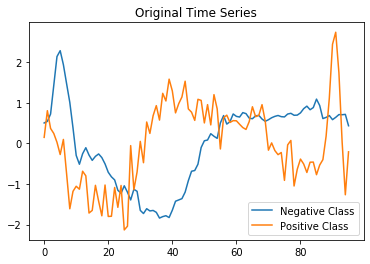

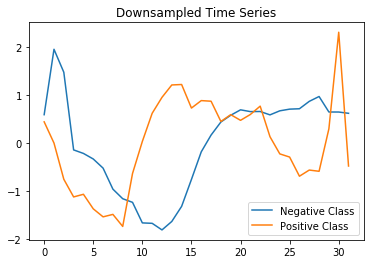

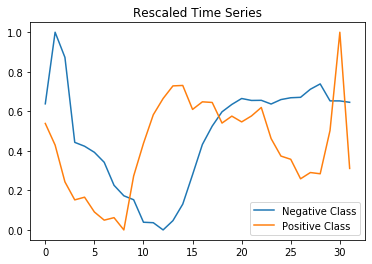

In [161]:
import matplotlib.pyplot as plt

toy_data=train_np[[0,1],:]
plt.plot(toy_data[0])
plt.plot(toy_data[1])
plt.legend(['Negative Class','Positive Class'])
plt.title('Original Time Series')

#downsampling
ds_data=paa(toy_data,3)
plt.figure()
plt.plot(ds_data[0])
plt.plot(ds_data[1])
plt.legend(['Negative Class','Positive Class'])
plt.title('Downsampled Time Series')

#rescaling
rescaled=rescale(ds_data)
plt.figure()
plt.plot(rescaled[0].T)
plt.plot(rescaled[1].T)
plt.legend(['Negative Class','Positive Class'])
plt.title('Rescaled Time Series')

Illustrating RP image embedding

Text(0.5, 1.0, 'RP-positive class')

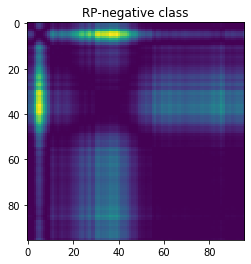

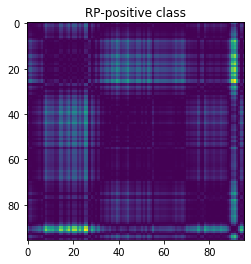

In [59]:
#RP embedding
RP=[]
for i in range(2):
    RP.append(r_plot(toy_data[i]))
    
plt.figure()
plt.imshow(RP[0])
plt.title('RP-negative class')
plt.figure()
plt.imshow(RP[1])
plt.title('RP-positive class')

Illustrating Gramian Angular Difference Field (GADF) embedding

Text(0.5, 1.0, 'GADF-positive class')

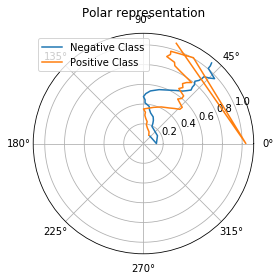

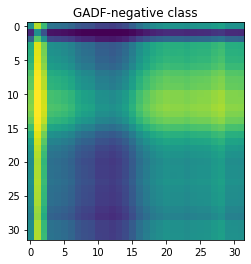

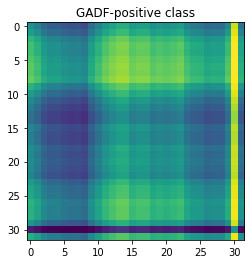

In [162]:
#polar embedding
phi_neg,r_neg=polar_rep(rescaled[0])
phi_pos,r_pos=polar_rep(rescaled[1])
plt.figure()
plt.polar(np.ravel(phi_neg),r_neg)
plt.polar(np.ravel(phi_pos),r_pos)
plt.legend(['Negative Class','Positive Class'])
plt.title('Polar representation')
plt.tight_layout()

#GADF embedding
GADF_i=[]
for i in range(2):
    GADF_i.append(GADF(rescaled[i]))
    
plt.figure()
plt.imshow(GADF_i[0])
plt.title('GADF-negative class')
plt.figure()
plt.imshow(GADF_i[1])
plt.title('GADF-positive class')


Generating RP and GADF images for ECG200

In [163]:
train_ds=paa(train_np,3)
test_ds=paa(test_np,3)
train_img_rp=np.empty(shape=(len(train_ds),32,32))
test_img_rp=np.empty(shape=(len(test_ds),32,32))
for i in range(len(train_ds)):
    train_img_rp[i,:,:]=r_plot(train_ds[i,:])
for i in range(len(test_ds)):  
    test_img_rp[i,:,:]=r_plot(test_ds[i,:])
print("generated rp images")

generated rp images


In [164]:
train_rs=rescale(train_ds)
test_rs=rescale(test_ds)
train_img_gadf=np.empty(shape=(len(train_rs),32,32))
test_img_gadf=np.empty(shape=(len(test_rs),32,32))
for i in range(len(train_rs)):
    train_img_gadf[i,:,:]=GADF(train_rs[i])
for i in range(len(test_ds)):  
    test_img_gadf[i,:,:]=GADF(test_rs[i])
print("generated GADF images")

generated GADF images


In [165]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import plot_model
from keras import optimizers

#setting up a default CNN

def CNN(train_img,test_img,train_labels, test_labels,batch_size=10,num_classes=2,epochs=500):

    # input image dimensions
    img_rows, img_cols = 32,32
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = (train_img, train_labels), (test_img, test_labels)
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    def labeling(y,num_classes):
      from sklearn.preprocessing import LabelEncoder
      encoder = LabelEncoder()
      encoder.fit(y)
      encoded_Y = encoder.transform(y)
      # convert integers to dummy variables (i.e. one hot encoded)
      dummy_y = keras.utils.np_utils.to_categorical(encoded_Y,num_classes)
      return(dummy_y)

    #from keras.utils.np_utils import to_categorical
    #one-hot encode target column
    y_train = labeling(np.ravel(y_train), num_classes)
    y_test = labeling(np.ravel(y_test), num_classes)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=(3,3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    history=model.fit(x_train, y_train,
              batch_size,
              epochs,
              verbose=0,
              validation_data=(x_test, y_test))
    return history

x_train shape: (100, 32, 32, 1)
100 train samples
100 test samples
max. Validation accuracy: 0.9399999976158142
max. Training accuracy: 1.0


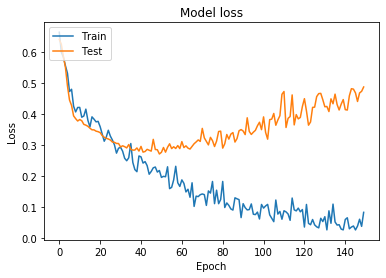

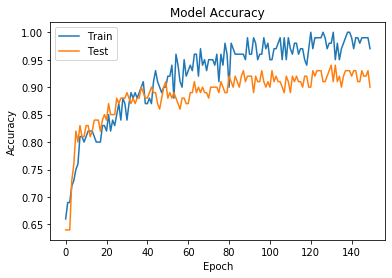

In [168]:
# Training with RP images
history=CNN(train_img_rp,test_img_rp,train_labels, test_labels,epochs=150)
print("max. Validation accuracy:",max(history.history['val_accuracy']))
print("max. Training accuracy:",max(history.history['accuracy']))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


x_train shape: (100, 32, 32, 1)
100 train samples
100 test samples
max. Validation accuracy: 0.8799999952316284
max. Training accuracy: 0.99


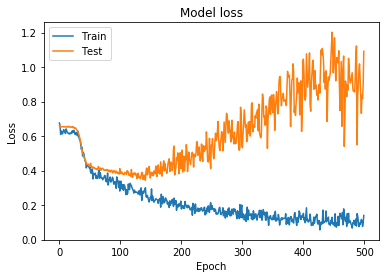

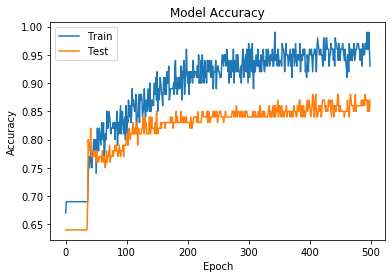

In [167]:
# Training with GADF images
history=CNN(train_img_gadf,test_img_gadf,train_labels, test_labels,epochs=500)
print("max. Validation accuracy:",max(history.history['val_accuracy']))
print("max. Training accuracy:",max(history.history['accuracy']))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()